In [34]:
import matplotlib.pyplot as plt # plotting
import numpy as np              # working with number arrays etc.
from netCDF4 import Dataset     # reading netcdf files
from numpy import trapz         # for integration

# all file paths: change according to file location
path_les="/Users/amrapallig/run/cvmix_analysis/les/"
path_adc="/Users/amrapallig/Desktop/cvmix/adc/convection/"
path_kpp="/Users/amrapallig/run/cvmix_analysis/les/KPP-CVMix/"
path_ke="/Users/amrapallig/run/cvmix_analysis/les/K-EPSILON-SG/"

In [35]:

# density calculation from given temp and salinity
def density_eos(t,s):
    density= 1026.0*(1.0-2e-4*(t-20)+8e-4*(s-35))
    return density


#rate of change of depth integrated potential energy calculation
def pot_energy2(temperature_0,temperature_t,salinity_0,salinity_t,depth,dtdz,dsdz,t=95):
    
     
   # depth=np.append(-0.5,depth)
    temp=20+dtdz*depth
    salt=35+dsdz*depth
    ind=np.where((depth)>=-100)  ##plots are weird with, 5 m doing worse than 10m if whole depth 100m is selected
    salt=salt[ind]
    temp=temp[ind]
    depth=depth[ind]
    density= density_eos(temp,salt)
    # depth integrated potential energy PE=density*9.81*depth
    area=trapz(density*9.81*depth,depth)
    PE_0=area  #/(depth[0]-depth[-1])

    
    #for final time
    #temp=temperature_t
    #salt=salinity_t

    temp=temperature_t[ind]
    salt=salinity_t[ind]
    density= density_eos(temp,salt)
    #plt.plot(density,depth)
    # depth integrated potential energy PE=density*9.81*depth
    # area under PE
    area=trapz(density*9.81*depth,depth)
    PE_t=area  #/(depth[0]-depth[-1])
    PE_rate_change=(PE_t-PE_0)/(3600*t)  # in Watt/m^2
    #print(PE_t)
    plt.plot(density,depth)

    return (PE_rate_change)


{'pe_c2_les': 0.00018287504878309037}

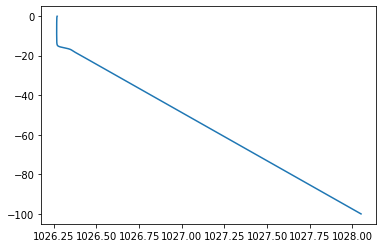

In [36]:
# time step
t = 96  # as KPP and KE have 95 hrs of data stratibg from zero
# range of time for averaging
t1 = t-12

results_les = {}
les= Dataset(path_les+'Cooling2.nc', mode='r')
results_les["pe_c2_les"] = pot_energy2(les.variables["temp"][0,:],
                                              np.nanmean(les.variables["temp"][t1:t,:],axis=0),
                                              les.variables["salt"][0,:],
                                              np.nanmean(les.variables["salt"][t1:t,:],axis=0),
                                              les.variables['zm'][:],
                                              dtdz=0.1,
                                              dsdz=0.0)
results_les

{'pe_c2_adcdtp5s': 0.00015683913420428308,
 'pe_c2_adcdt1s': 0.00016149166507417695,
 'pe_c2_adcdt2s': 0.00016714914587506076,
 'pe_c2_adcdt5s': 0.0001627065700353586}

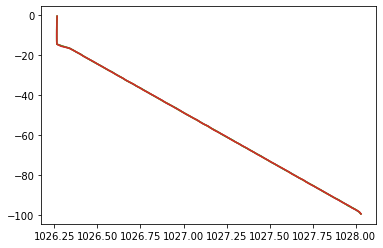

In [37]:
# ADC
# time step
t = 96  # as KPP and KE have 95 hrs of data stratibg from zero
# range of time for averaging
t1 = t-12
path_adc="/Users/amrapallig/run/cvmix_test/forward/output/convection/time_sensitivity/"
results_adc_c2_adcdt = {}


file_names_adcdt = ["p5s","1s","2s","5s"]

for fn in file_names_adcdt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')
        dtdz=0.1; dsdz=0.0 #for c2
       
                         
        # compute pot
        results_adc_c2_adcdt[f"pe_c2_adcdt{fn}"] = pot_energy2(mf.variables["temperature"][0,0,:],
                                                   np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                                   mf.variables["salinity"][0,0,:],
                                                  np.nanmean(mf.variables["salinity"][t1:t,0,:],axis=0),
                                                  fh.variables['zMid'][0,0,:],
                                                  dtdz,
                                                  dsdz)
results_adc_c2_adcdt


In [38]:
relative_errors_adcdt = {}

file_names_adcdt = ["p5s","1s","2s","5s"]
for fn in file_names_adcdt:
    numerator =  results_adc_c2_adcdt[f"pe_c2_adcdt{fn}"]-results_les["pe_c2_les"] 
    relative_errors_adcdt[f"c2_adcdt{fn}"] = numerator/results_les["pe_c2_les"]
        
relative_errors_adcdt


{'c2_adcdtp5s': -0.14236996655398684,
 'c2_adcdt1s': -0.11692892962274165,
 'c2_adcdt2s': -0.08599261087105566,
 'c2_adcdt5s': -0.11028556865433167}

{'pe_c2_dt5min': 0.00016942417667361727,
 'pe_c2_dt10min': 0.00016954579010431528,
 'pe_c2_dt30min': 0.00017003621315659837,
 'pe_c2_dt1hr': 0.00017288265385997226,
 'pe_c2_dt2hr': 0.00017432847919694164}

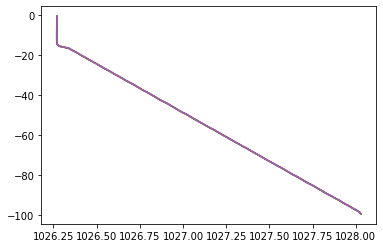

In [39]:
# ADC
path_adc="/Users/amrapallig/run/cvmix_test/forward/output/convection/time_sensitivity/"
results_adc_c2_dt = {}


file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_dt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt1s_dt{fn}.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt1s_dt{fn}.nc', mode='r')
        dtdz=0.1; dsdz=0.0 #for c2
        
        if fn=="1hr":
            t=96; t1=t-4                 #1hr
        if fn=="2hr":
            t=int(96/2); t1=t-int(4/2)   #2hr
        if fn=="30min":
            t=int(96*2); t1=t-int(4*2)   #30min
        if fn=="10min":
            t=int(96*6); t1=t-int(4*6)   #10min
        if fn=="5min":
            t=int(96*12); t1=t-int(4*12)  #5minmin
        
        # compute pot
        results_adc_c2_dt[f"pe_c2_dt{fn}"] = pot_energy2(mf.variables["temperature"][0,0,:],
                                                   np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                                   mf.variables["salinity"][0,0,:],
                                                  np.nanmean(mf.variables["salinity"][t1:t,0,:],axis=0),
                                                  fh.variables['zMid'][0,0,:],
                                                  dtdz,
                                                  dsdz)
results_adc_c2_dt

In [40]:
relative_errors_dt = {}

file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_dt:
    numerator = results_adc_c2_dt[f"pe_c2_dt{fn}"]-results_les["pe_c2_les"] 
    relative_errors_dt[f"c2_dt{fn}"] = numerator/results_les["pe_c2_les"]
    
    
        
relative_errors_dt


{'c2_dt5min': -0.07355225438888217,
 'c2_dt10min': -0.07288724605938471,
 'c2_dt30min': -0.07020550759617436,
 'c2_dt1hr': -0.05464055916654972,
 'c2_dt2hr': -0.04673447604263332}

In [41]:
relative_errors_dt

{'c2_dt5min': -0.07355225438888217,
 'c2_dt10min': -0.07288724605938471,
 'c2_dt30min': -0.07020550759617436,
 'c2_dt1hr': -0.05464055916654972,
 'c2_dt2hr': -0.04673447604263332}

Text(10, -0.75, '(b)')

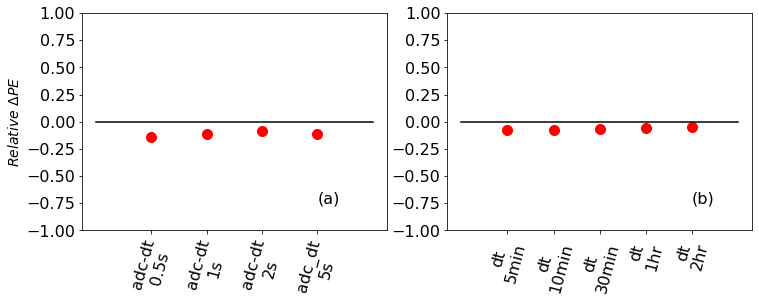

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)

a=2,4,6,8
plt.plot(a[0],relative_errors_adcdt["c2_adcdtp5s"],'or',markersize=10)
plt.plot(a[1],relative_errors_adcdt["c2_adcdt1s"],'or',markersize=10)
plt.plot(a[2],relative_errors_adcdt["c2_adcdt2s"],'or',markersize=10)
plt.plot(a[3],relative_errors_adcdt["c2_adcdt5s"],'or',markersize=10)

#plt.plot(a[0],c4_adcp5s,'ok',markersize=10)
#plt.plot(a[1],c4_adc1s,'ok',markersize=10)
#plt.plot(a[2],c4_adc2s,'ok',markersize=10)
#plt.plot(a[3],c4_adc5s,'ok',markersize=10)

plt.ylim(-1,1)

plt.plot([0,10],[0,0],'-k')
plt.xticks([2,4,6,8], ['adc-dt\n0.5s', 'adc-dt\n1s', 'adc-dt\n2s','adc_dt\n5s'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(8,-0.75,"(a)",fontsize=16)

plt.subplot(122)

a=2,4,6,8,10
plt.plot(a[1],relative_errors_dt["c2_dt10min"],'or',markersize=10)
plt.plot(a[2],relative_errors_dt["c2_dt30min"],'or',markersize=10)
plt.plot(a[3],relative_errors_dt["c2_dt1hr"],'or',markersize=10)
plt.plot(a[4],relative_errors_dt["c2_dt2hr"],'or',markersize=10)
plt.plot(a[0],relative_errors_dt["c2_dt5min"],'or',markersize=10)


plt.ylim(-1,1)

plt.plot([0,12],[0,0],'-k')
plt.xticks([2,4,6,8,10], ['dt\n5min','dt\n10min', 'dt\n30min', 'dt\n1hr','dt\n2hr'],rotation=75,fontsize=14)
#plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
#
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(10,-0.75,"(b)",fontsize=16)


In [33]:
#results_les_maxN2 = {}
#les= Dataset(path_les+'Cooling2.nc', mode='r')
#results_les["pe_c2_les"] = bld_max_N2(les.variables["temp"][:,:],les.variables['zm'][:])

#plt.plot(results_les["pe_c2_les"])


In [11]:
######## alternative calculation

In [12]:
# def bld_max_N2(temp,z,t):
#     N2=np.gradient(temp[:-2,:],z,axis=1)
#     bld=np.zeros(len(N2[:,0]))
#     for i in np.arange(len(N2[:,0])):    
#         indx=N2[i,:].argmax()
#         bld[i]=z[indx]
#     time=t[:-2]   
#     return (bld,time) 
# les= Dataset(path_les+'Cooling2.nc', mode='r')
#osbl_c2_les,osbl_c2_les_time=bld_max_N2(les.variables["temp"][:,:],
#                                        les.variables['zm'][:],
#                                        les.variables['Time'][:])
#plt.plot(osbl_c2_les_time,osbl_c2_les)

In [13]:
def bld_max_N2(temp,z):  #for timeseries
    N2=np.gradient(temp[:-1,:],z,axis=1)
    bld=np.zeros(len(N2[:,0]))
    for i in np.arange(len(N2[:,0])):    
        indx=N2[i,:].argmax()
        bld[i]=z[indx]
   
    return (bld) 

In [14]:
def bld_max_N2_2(temp,z):  #for particular time
    N2=np.gradient(temp,z)
    indx=N2.argmax()
    bld=z[indx]
    return (bld) 

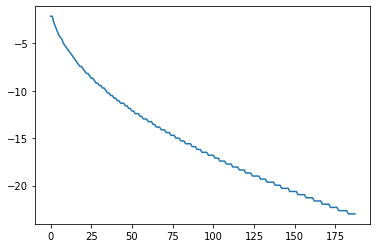

In [15]:
les= Dataset(path_les+'Cooling2.nc', mode='r')
osbl_c2_les=bld_max_N2(les.variables["temp"][:,:],
                                        les.variables['zm'][:])
                                        
plt.plot(osbl_c2_les)

In [16]:
osbl_les = {}
osbl_les_timeseries = {}
osbl_adcdt = {}
osbl_dt = {}
osbl_adcdt_timeseries = {}
osbl_dt_timeseries = {}

les= Dataset(path_les+'Cooling2.nc', mode='r')
osbl_les_timeseries["osbl_c2"]=bld_max_N2(les.variables["temp"][:,:],
                                        les.variables['zm'][:])

t=96; t1=t-4 
osbl_les["osbl_c2"]=bld_max_N2_2(np.nanmean(les.variables["temp"][t1:t,:],axis=0),
                                        les.variables['zm'][:])

file_names_adcdt = ["p5s","1s","2s","5s"]
file_names_dt = ["5min","10min","30min","1hr","2hr"]


for fn in file_names_adcdt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')
        osbl_adcdt_timeseries[f"osbl_c2_adcdt_{fn}"] = bld_max_N2(mf.variables["temperature"][:,0,:],
                                fh.variables['zMid'][0,0,:],)
        t=96; t1=t-4 
        osbl_adcdt[f"osbl_c2_adcdt_{fn}"] = bld_max_N2_2(np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                            fh.variables['zMid'][0,0,:])
        
path_adc="/Users/amrapallig/run/cvmix_test/forward/output/convection/time_sensitivity/"                                                
for fn in file_names_dt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt1s_dt{fn}.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt1s_dt{fn}.nc', mode='r')
       
        if fn=="1hr":
            t=96; t1=t-4                 #1hr
        if fn=="2hr":
            t=int(96/2); t1=t-int(4/2)   #2hr
        if fn=="30min":
            t=int(96*2); t1=t-int(4*2)   #30min
        if fn=="10min":
            t=int(96*6); t1=t-int(4*6)   #10min
        if fn=="5min":
            t=int(96*12); t1=t-int(4*12) 
        
        print(mf.variables["temperature"][:,0,:].shape)
        osbl_dt_timeseries[f"osbl_c2_dt_{fn}"] = bld_max_N2(mf.variables["temperature"][:,0,:],
                                fh.variables['zMid'][0,0,:])
 
        osbl_dt[f"osbl_c2_dt_{fn}"] = bld_max_N2_2(np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                fh.variables['zMid'][0,0,:])
        

(1441, 100)
(721, 100)
(241, 100)
(121, 100)
(61, 100)


In [17]:
96*6

576

In [18]:
osbl_dt


{'osbl_c2_dt_5min': -16.5,
 'osbl_c2_dt_10min': -16.5,
 'osbl_c2_dt_30min': -16.5,
 'osbl_c2_dt_1hr': -16.5,
 'osbl_c2_dt_2hr': -16.5}

In [19]:
osbl_adcdt

{'osbl_c2_adcdt_p5s': -16.5,
 'osbl_c2_adcdt_1s': -16.5,
 'osbl_c2_adcdt_2s': -16.5,
 'osbl_c2_adcdt_5s': -16.5}

In [20]:
osbl_les

{'osbl_c2': -16.49266242980957}

In [21]:
relative_errors_dt = {}

file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_dt:
    numerator =   osbl_dt[f"osbl_c2_dt_{fn}"]-osbl_les["osbl_c2"]
    relative_errors_dt[f"c2_dt{fn}"] = (numerator/osbl_les["osbl_c2"])
    
relative_errors_adcdt = {}

file_names_adcdt = ["p5s","1s","2s","5s"]
for fn in file_names_adcdt:
    numerator =  osbl_adcdt[f"osbl_c2_adcdt_{fn}"]-osbl_les["osbl_c2"]
    relative_errors_adcdt[f"c2_adcdt{fn}"] = (numerator/osbl_les["osbl_c2"])
    

In [22]:
relative_errors_dt

{'c2_dt5min': 0.0004448990708236068,
 'c2_dt10min': 0.0004448990708236068,
 'c2_dt30min': 0.0004448990708236068,
 'c2_dt1hr': 0.0004448990708236068,
 'c2_dt2hr': 0.0004448990708236068}

In [23]:
relative_errors_adcdt

{'c2_adcdtp5s': 0.0004448990708236068,
 'c2_adcdt1s': 0.0004448990708236068,
 'c2_adcdt2s': 0.0004448990708236068,
 'c2_adcdt5s': 0.0004448990708236068}

(array([-0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

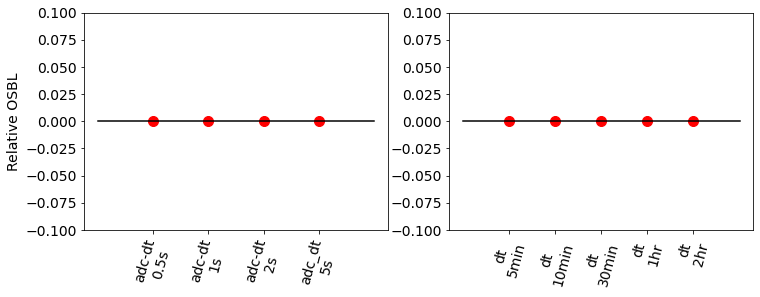

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(121)

a=2,4,6,8
plt.plot(a[0],relative_errors_adcdt["c2_adcdtp5s"],'or',markersize=10)
plt.plot(a[1],relative_errors_adcdt["c2_adcdt1s"],'or',markersize=10)
plt.plot(a[2],relative_errors_adcdt["c2_adcdt2s"],'or',markersize=10)
plt.plot(a[3],relative_errors_adcdt["c2_adcdt5s"],'or',markersize=10)

#plt.plot(a[0],c4_adcp5s,'ok',markersize=10)
#plt.plot(a[1],c4_adc1s,'ok',markersize=10)
#plt.plot(a[2],c4_adc2s,'ok',markersize=10)
#plt.plot(a[3],c4_adc5s,'ok',markersize=10)


plt.ylim(-0.1,0.1)

plt.plot([0,10],[0,0],'-k')
plt.xticks([2,4,6,8], ['adc-dt\n0.5s', 'adc-dt\n1s', 'adc-dt\n2s','adc_dt\n5s'],rotation=75,fontsize=14)
plt.ylabel("Relative OSBL",fontsize=14)
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)

a=2,4,6,8,10
plt.plot(a[1],relative_errors_dt["c2_dt10min"],'or',markersize=10)
plt.plot(a[2],relative_errors_dt["c2_dt30min"],'or',markersize=10)
plt.plot(a[3],relative_errors_dt["c2_dt1hr"],'or',markersize=10)
plt.plot(a[4],relative_errors_dt["c2_dt2hr"],'or',markersize=10)
plt.plot(a[0],relative_errors_dt["c2_dt5min"],'or',markersize=10)


plt.ylim(-0.1,0.1)

plt.plot([0,12],[0,0],'-k')
plt.xticks([2,4,6,8,10], ['dt\n5min','dt\n10min', 'dt\n30min', 'dt\n1hr','dt\n2hr'],rotation=75,fontsize=14)
#plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
#
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Text(20, -14, '(b)')

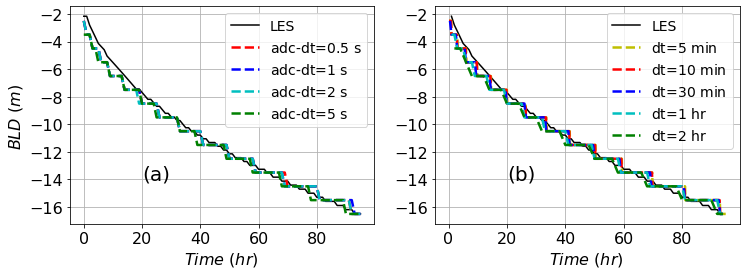

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax, ax2) = plt.subplots(1, 2, figsize=[12, 4])
axins = inset_axes(ax, width=1.3, height=0.9)
#plt.figure(figsize=(12,4))
plt.subplot(121)


plt.plot(osbl_les_timeseries["osbl_c2"][:96],'k',linewidth=1.5)
plt.plot(osbl_adcdt_timeseries["osbl_c2_adcdt_p5s"][:96],'--r',linewidth=2.5)
plt.plot(osbl_adcdt_timeseries["osbl_c2_adcdt_1s"][:96],'--b',linewidth=2.5)
plt.plot(osbl_adcdt_timeseries["osbl_c2_adcdt_2s"][:96],'--c',linewidth=2.5)
plt.plot(osbl_adcdt_timeseries["osbl_c2_adcdt_5s"][:96],'--g',linewidth=2.5)

#plt.xlabel('$Time$ $(hrs)$',fontsize=14)
#plt.ylabel('$BLD$ $(m)$  $@ max(N^2)$',fontsize=14)
plt.grid() 
plt.legend(["LES","adc-dt=$0.5$ s","adc-dt=$1$ s","adc-dt=$2$ s","adc-dt=$5$ s"], fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$BLD$ $(m)$ ',fontsize=16)
plt.xlabel('$Time$ $(hr)$ ',fontsize=16)
plt.text(20,-14,"(a)",fontsize=20)


plt.subplot(122)

timeles=np.arange(len(osbl_les_timeseries["osbl_c2"][:]))
timeadc_1hr=np.arange(len(osbl_dt_timeseries["osbl_c2_dt_1hr"]))
timeadc_2hr=np.arange(len(osbl_dt_timeseries["osbl_c2_dt_2hr"]))*2
timeadc_30min=np.arange(len(osbl_dt_timeseries["osbl_c2_dt_30min"]))/2
timeadc_10min=np.arange(len(osbl_dt_timeseries["osbl_c2_dt_10min"]))/6
timeadc_5min=np.arange(len(osbl_dt_timeseries["osbl_c2_dt_5min"]))/12


plt.plot(timeles[1:95],osbl_les_timeseries["osbl_c2"][1:95],'k',linewidth=1.5)
plt.plot(timeadc_5min[2:95*12],osbl_dt_timeseries["osbl_c2_dt_5min"][2:95*12],'--y',linewidth=2.5)
plt.plot(timeadc_10min[1:95*6],osbl_dt_timeseries["osbl_c2_dt_10min"][1:95*6],'--r',linewidth=2.5)
plt.plot(timeadc_30min[1:95*2],osbl_dt_timeseries["osbl_c2_dt_30min"][1:95*2],'--b',linewidth=2.5)
plt.plot(timeadc_1hr[1:95],osbl_dt_timeseries["osbl_c2_dt_1hr"][1:95],'--c',linewidth=2.5)
plt.plot(timeadc_2hr[1:48],osbl_dt_timeseries["osbl_c2_dt_2hr"][1:48],'--g',linewidth=2.5)

#plt.xlabel('$Time$ $(hrs)$',fontsize=14)
#plt.ylabel('$BLD$ $(m)$  $@ max(N^2)$',fontsize=14)
plt.grid() 
plt.legend(["LES","dt=$5$ min","dt=$10$ min","dt=$30$ min","dt=$1$ hr","dt=$2$ hr"], fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylabel('$BLD$ $(m)$ ',fontsize=14)
plt.xlabel('$Time$ $(hr)$ ',fontsize=16)
plt.text(20,-14,"(b)",fontsize=20)


In [ ]:
timeadc_1hr[0:95]

In [ ]:
timeadc_2hr[0:48]

In [ ]:
timeadc_30min[0:95*2]